Device: cpu

Training Transformer...
Epoch 1/20 | Train Loss: 7.5909 | Val Loss: 0.3788
Epoch 2/20 | Train Loss: 1.5335 | Val Loss: 0.1849
Epoch 3/20 | Train Loss: 1.1388 | Val Loss: 0.1641
Epoch 4/20 | Train Loss: 0.9990 | Val Loss: 0.1843
Epoch 5/20 | Train Loss: 0.9495 | Val Loss: 0.1614
Epoch 6/20 | Train Loss: 0.9559 | Val Loss: 0.2316
Epoch 7/20 | Train Loss: 0.8828 | Val Loss: 0.2064
Epoch 8/20 | Train Loss: 0.9083 | Val Loss: 0.1929
Epoch 9/20 | Train Loss: 0.8459 | Val Loss: 0.2026
Epoch 10/20 | Train Loss: 0.8093 | Val Loss: 0.2351
Epoch 11/20 | Train Loss: 0.7956 | Val Loss: 0.2659
Epoch 12/20 | Train Loss: 0.8151 | Val Loss: 0.2082
Epoch 13/20 | Train Loss: 0.8425 | Val Loss: 0.2325
Epoch 14/20 | Train Loss: 0.7990 | Val Loss: 0.2588
Epoch 15/20 | Train Loss: 0.7816 | Val Loss: 0.2279
Epoch 16/20 | Train Loss: 0.7458 | Val Loss: 0.2325
Epoch 17/20 | Train Loss: 0.7658 | Val Loss: 0.2556
Epoch 18/20 | Train Loss: 0.7622 | Val Loss: 0.2894
Epoch 19/20 | Train Loss: 0.7460 | V

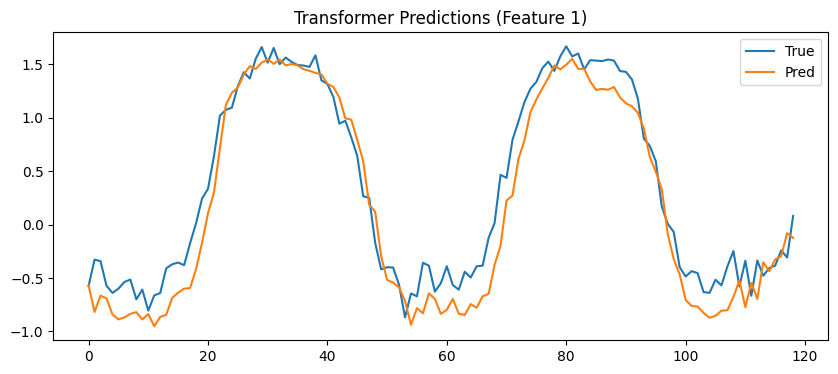

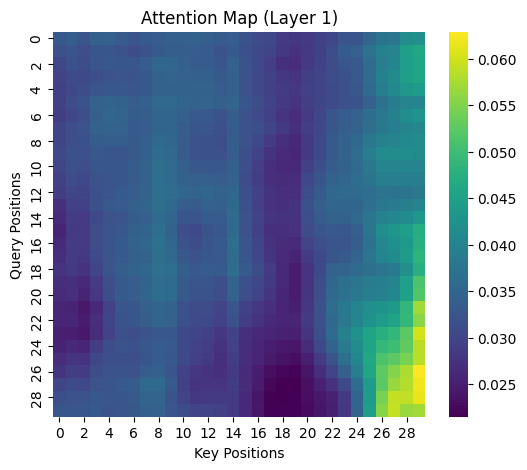

In [15]:
# IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import math
import seaborn as sns

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# 1. SIMPLE SYNTHETIC DATA GENERATION

def create_dataset(n_steps=1000, n_features=5):
    t = np.arange(n_steps)

    data = []
    for i in range(n_features):
        seasonal = np.sin(2*np.pi*t/(50 + i*10))
        trend = 0.0005 * t
        nonlinear = 0.3*np.sin(seasonal*3)
        noise = 0.1 * np.random.randn(n_steps)
        series = seasonal + trend + nonlinear + noise
        data.append(series)

    df = pd.DataFrame(np.array(data).T, columns=[f"f{i+1}" for i in range(n_features)])
    return df

df = create_dataset()
df.head()

# 2. SLIDING WINDOW DATASET

class WindowDataset(Dataset):
    def __init__(self, data, input_len=30, output_len=1):
        self.x = []
        self.y = []
        for i in range(len(data) - input_len - output_len):
            self.x.append(data[i:i+input_len])
            self.y.append(data[i+input_len:i+input_len+output_len])
        self.x = torch.tensor(self.x, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Train/Val/Test split

scaler = StandardScaler()
scaled = scaler.fit_transform(df.values)

train_size = int(len(scaled)*0.7)
val_size = int(len(scaled)*0.15)

train = scaled[:train_size]
val = scaled[train_size:train_size+val_size]
test = scaled[train_size+val_size:]

input_len = 30
output_len = 1

train_ds = WindowDataset(train, input_len, output_len)
val_ds = WindowDataset(val, input_len, output_len)
test_ds = WindowDataset(test, input_len, output_len)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

# 3. MODELS
# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, n_features, d_model=64, num_layers=2, nheads=4):
        super().__init__()
        self.input_layer = nn.Linear(n_features, d_model)
        self.pos = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nheads,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Linear(d_model, n_features)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.pos(x)
        x = self.encoder(x)
        out = self.output(x[:, -1])
        return out

# LSTM Baseline
class LSTMModel(nn.Module):
    def __init__(self, n_features, hidden=64, layers=2):
        super().__init__()
        self.lstm = nn.LSTM(n_features, hidden, layers, batch_first=True)
        self.fc = nn.Linear(hidden, n_features)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1])
        return out

# 4. TRAINING LOOP
def train_model(model, train_loader, val_loader, epochs=20):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb[:, 0].to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb[:, 0].to(DEVICE)
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item()

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return model

# Train both models
transformer = TransformerModel(n_features=5)
lstm = LSTMModel(n_features=5)

print("\nTraining Transformer...")
transformer = train_model(transformer, train_loader, val_loader)

print("\nTraining LSTM Baseline...")
lstm = train_model(lstm, train_loader, val_loader)

# 5. EVALUATION
def evaluate(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            pred = model(xb).cpu().numpy()
            preds.append(pred)
            trues.append(yb[:, 0].numpy())

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    preds_inv = scaler.inverse_transform(preds)
    trues_inv = scaler.inverse_transform(trues)

    mse = mean_squared_error(trues_inv, preds_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(trues_inv, preds_inv)

    return mse, rmse, mae, preds_inv, trues_inv


t_mse, t_rmse, t_mae, t_pred, t_true = evaluate(transformer, test_loader)
l_mse, l_rmse, l_mae, l_pred, l_true = evaluate(lstm, test_loader)

print("\nFINAL METRICS")
print("Transformer: ", t_mse, t_rmse, t_mae)
print("LSTM:        ", l_mse, l_rmse, l_mae)

# 6. Visualize Predictions
plt.figure(figsize=(10,4))
plt.title("Transformer Predictions (Feature 1)")
plt.plot(t_true[:200,0], label="True")
plt.plot(t_pred[:200,0], label="Pred")
plt.legend()
plt.show()

# 7. Simple Attention Visualization
# Using encoder layer self-attention
layer = transformer.encoder.layers[0].self_attn

# Create a batch sample
xb, _ = next(iter(test_loader))
xb = xb[:1].to(DEVICE)

# Manually run first layer to get attention weights
with torch.no_grad():
    inp = transformer.input_layer(xb)
    inp = transformer.pos(inp)
    _, attn = layer(inp, inp, inp, need_weights=True)

att = attn.squeeze().cpu().numpy()

plt.figure(figsize=(6,5))
sns.heatmap(att, cmap="viridis")
plt.title("Attention Map (Layer 1)")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")
plt.show()

